Version 2025.01.09 - A. Lundervold

Lab 2 DL: using the `elemd219-2025`conda environment 

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/ELMED219-2025/blob/main/Lab2-DL/04-psn-explore.ipynb)

# Patient similarity networks - explore

**Claude 3.5 Sonnet**


In [7]:
# Check if we are in colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

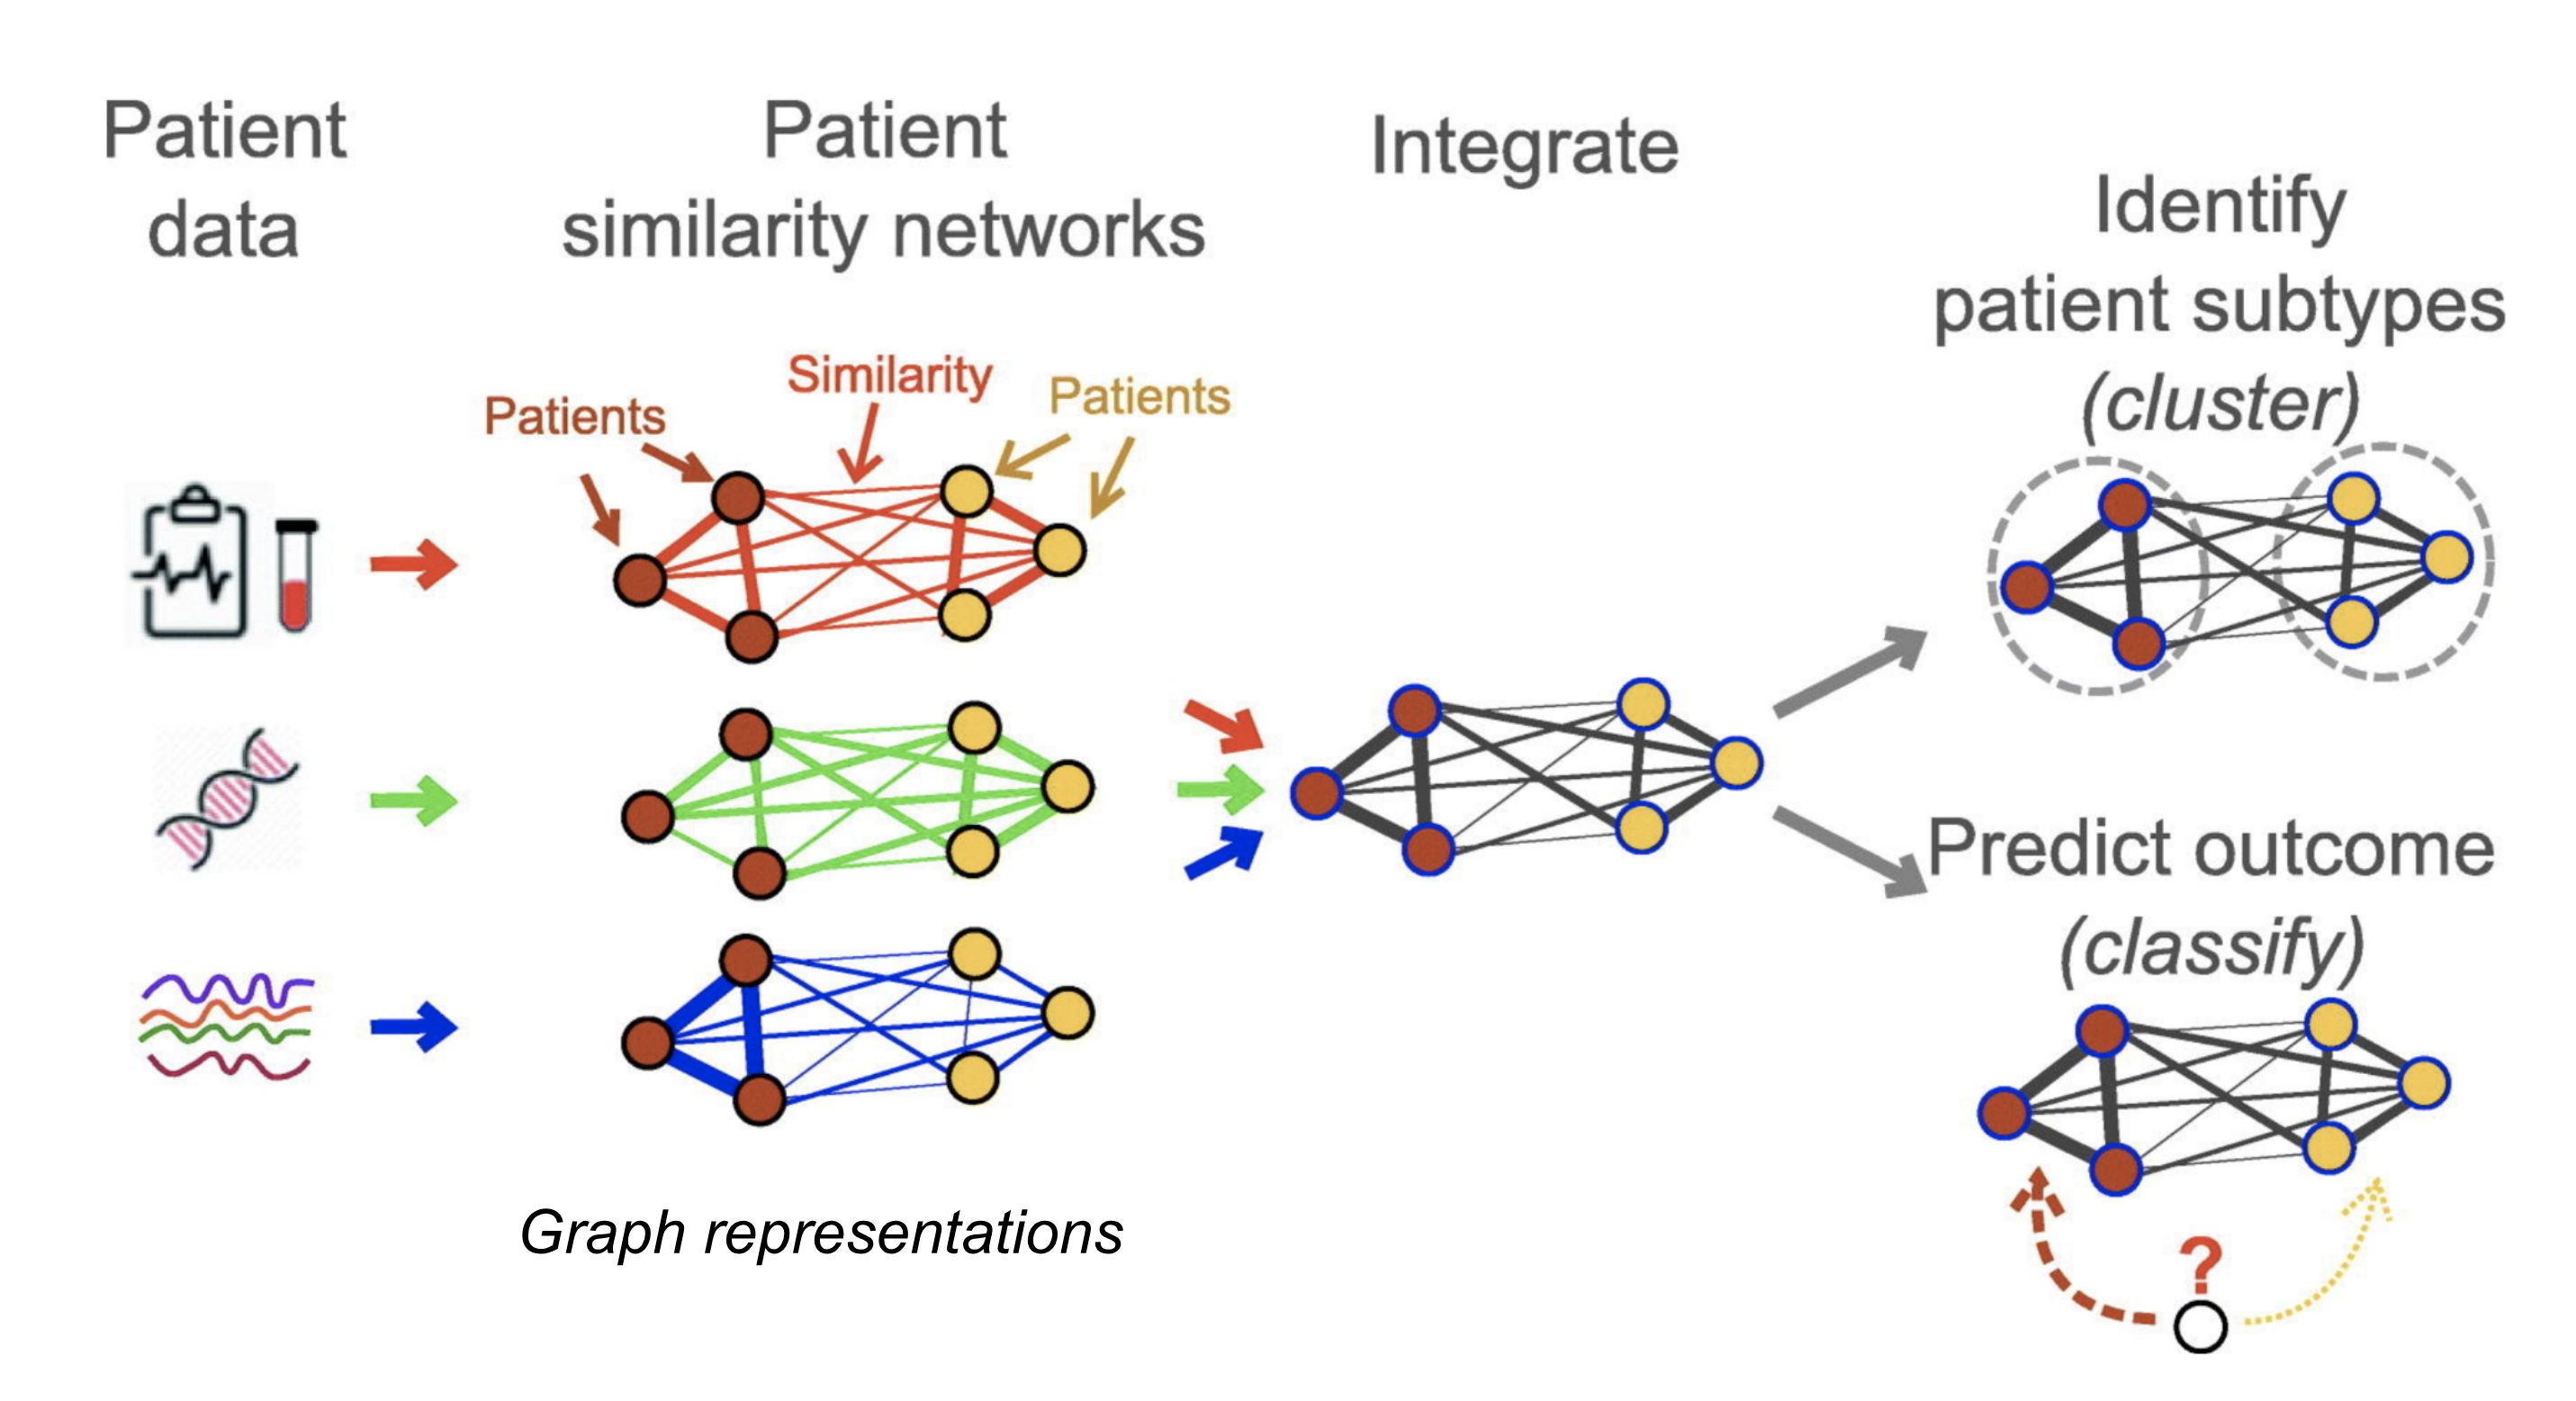

In [8]:
from IPython.display import display,Image

if is_colab():
    !wget https://raw.githubusercontent.com/MMIV-ML/BMED365-2025/main/Lab2-DL/assets/PSN-sketch.png
    display(Image('PSN-sketch.png'))
else:
    display(Image(filename='./assets/PSN-sketch.png'))

_Make a PoC prototype in Python based on the uploaded figure_


I'll help create a proof-of-concept prototype in Python that demonstrates the patient similarity network and clustering approach shown in the figure. We'll use some common libraries to implement this pipeline.



I've created a proof-of-concept implementation that follows the workflow shown in the figure. Here's a breakdown of the main components:

1. Data Integration:
- Handles three types of patient data: clinical, genomic, and expression data
- Normalizes each data type using StandardScaler
- Creates similarity networks for each data type using cosine similarity
- Integrates the networks by combining edges with weighted averaging

2. Patient Similarity Networks:
- Constructs graphs using NetworkX
- Uses similarity threshold to determine connections between patients
- Maintains edge weights based on similarity scores

3. Subtype Identification:
- Implements spectral clustering to identify patient subtypes
- Converts the integrated network to an adjacency matrix for clustering
- Returns cluster assignments for each patient

4. Outcome Prediction:
- Uses Random Forest Classifier for outcome prediction
- Can train on combined feature sets
- Provides prediction functionality for new patients

The code includes a main() function with synthetic data generation for demonstration purposes. You can adapt this to your real data by:

1. Loading your actual patient data instead of the synthetic data
2. Adjusting the similarity_threshold parameter
3. Modifying the number of clusters in identify_subtypes()
4. Customizing the features used for outcome prediction

Would you like me to explain any particular part in more detail or help you adapt it to your specific use case?

_Please make illustrative figures for the constructed graphs (and their adjacency matrices) , for the identification of patient subtypes, and for the predictions of new patients._

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

class PatientSimilarityNetwork:
    def __init__(self, similarity_threshold=0.7):
        self.similarity_threshold = similarity_threshold
        self.scaler = StandardScaler()
        self.clusters = None
        self.classifier = RandomForestClassifier(random_state=42)
        
    def create_patient_network(self, clinical_data=None, genomic_data=None, expression_data=None):
        """
        Create similarity networks based on different data types and integrate them.
        """
        networks = []
        
        # Process each data type if provided
        for data, name in zip(
            [clinical_data, genomic_data, expression_data],
            ['clinical', 'genomic', 'expression']
        ):
            if data is not None:
                # Normalize data
                normalized_data = self.scaler.fit_transform(data)
                
                # Calculate similarity matrix
                similarity_matrix = cosine_similarity(normalized_data)
                
                # Create network
                network = nx.Graph()
                
                # Add nodes
                for i in range(len(similarity_matrix)):
                    network.add_node(i, data_type=name)
                
                # Add edges where similarity exceeds threshold
                for i in range(len(similarity_matrix)):
                    for j in range(i + 1, len(similarity_matrix)):
                        if similarity_matrix[i, j] >= self.similarity_threshold:
                            network.add_edge(i, j, weight=similarity_matrix[i, j])
                
                networks.append(network)
        
        # If only one network, return it
        if len(networks) == 1:
            return networks[0]
        
        # Integrate networks if multiple exist
        integrated_network = nx.Graph()
        
        # Add all nodes
        for network in networks:
            integrated_network.add_nodes_from(network.nodes(data=True))
        
        # Combine edges with weights
        for network in networks:
            for u, v, data in network.edges(data=True):
                if integrated_network.has_edge(u, v):
                    current_weight = integrated_network[u][v]['weight']
                    integrated_network[u][v]['weight'] = (current_weight + data['weight']) / 2
                else:
                    integrated_network.add_edge(u, v, **data)
        
        return integrated_network
    
    def identify_subtypes(self, integrated_network, n_clusters=2):
        """
        Identify patient subtypes using spectral clustering.
        """
        adjacency_matrix = nx.to_numpy_array(integrated_network)
        
        clustering = SpectralClustering(
            n_clusters=n_clusters,
            affinity='precomputed',
            random_state=42
        )
        
        self.clusters = clustering.fit_predict(adjacency_matrix)
        return self.clusters
    
    def train_outcome_predictor(self, X, y):
        """Train a classifier to predict patient outcomes."""
        self.classifier.fit(X, y)
    
    def predict_outcome(self, X):
        """Predict outcomes for new patients."""
        return self.classifier.predict(X)

class NetworkVisualizer:
    def __init__(self, figsize=(15, 5)):
        self.figsize = figsize
        
    def plot_individual_networks(self, networks, titles):
        """Plot individual similarity networks side by side"""
        fig, axes = plt.subplots(1, len(networks), figsize=self.figsize)
        if len(networks) == 1:
            axes = [axes]
            
        for ax, network, title in zip(axes, networks, titles):
            pos = nx.spring_layout(network, k=1/np.sqrt(len(network.nodes())), seed=42)
            
            nx.draw_networkx_nodes(network, pos, 
                                 node_color='lightblue',
                                 node_size=100,
                                 ax=ax)
            
            edge_weights = [d['weight'] for (u, v, d) in network.edges(data=True)]
            nx.draw_networkx_edges(network, pos,
                                 width=[w * 2 for w in edge_weights],
                                 alpha=0.5,
                                 ax=ax)
            
            ax.set_title(title)
            ax.axis('off')
            
        plt.tight_layout()
        return fig
    
    def plot_adjacency_matrices(self, networks, titles):
        """Plot adjacency matrices for each network"""
        fig, axes = plt.subplots(1, len(networks), figsize=self.figsize)
        if len(networks) == 1:
            axes = [axes]
            
        for ax, network, title in zip(axes, networks, titles):
            adj_matrix = nx.to_numpy_array(network)
            sns.heatmap(adj_matrix, 
                       ax=ax,
                       cmap='YlOrRd',
                       square=True,
                       cbar_kws={'label': 'Similarity'})
            ax.set_title(title)
            
        plt.tight_layout()
        return fig
    
    def plot_integrated_network_with_clusters(self, integrated_network, clusters):
        """Plot integrated network with node colors representing clusters"""
        fig, ax = plt.subplots(figsize=(10, 10))
        
        pos = nx.spring_layout(integrated_network, k=1/np.sqrt(len(integrated_network.nodes())), seed=42)
        
        unique_clusters = len(np.unique(clusters))
        colors = plt.cm.Set3(np.linspace(0, 1, unique_clusters))
        node_colors = [colors[c] for c in clusters]
        
        nx.draw_networkx_nodes(integrated_network, pos,
                             node_color=node_colors,
                             node_size=200)
        
        edge_weights = [d['weight'] for (u, v, d) in integrated_network.edges(data=True)]
        nx.draw_networkx_edges(integrated_network, pos,
                             width=[w * 2 for w in edge_weights],
                             alpha=0.3)
        
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=colors[i], 
                                    label=f'Cluster {i}',
                                    markersize=10)
                         for i in range(unique_clusters)]
        ax.legend(handles=legend_elements)
        
        ax.set_title('Integrated Network with Patient Subtypes')
        ax.axis('off')
        return fig
    
    def plot_cluster_characteristics(self, features_df, clusters):
        """Plot feature distributions across clusters using t-SNE"""
        tsne = TSNE(n_components=2, random_state=42)
        features_2d = tsne.fit_transform(features_df)
        
        fig, ax = plt.subplots(figsize=(10, 8))
        
        scatter = ax.scatter(features_2d[:, 0], features_2d[:, 1],
                           c=clusters, cmap='Set3',
                           s=100, alpha=0.6)
        
        legend = ax.legend(*scatter.legend_elements(),
                          title="Clusters",
                          loc="center left",
                          bbox_to_anchor=(1, 0.5))
        
        ax.set_title('Patient Subtypes in Feature Space (t-SNE)')
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')
        
        plt.tight_layout()
        return fig
    
    def plot_prediction_confidence(self, probabilities, predicted_labels):
        """Plot prediction confidence for new patients"""
        fig, ax = plt.subplots(figsize=(10, 6))
        
        x = np.arange(len(probabilities))
        bars = ax.bar(x, [max(prob) for prob in probabilities])
        
        for bar, label in zip(bars, predicted_labels):
            bar.set_color(plt.cm.Set3(label / len(np.unique(predicted_labels))))
        
        ax.set_ylim(0, 1)
        ax.set_xlabel('Patient ID')
        ax.set_ylabel('Prediction Confidence')
        ax.set_title('Outcome Prediction Confidence for New Patients')
        
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor=plt.cm.Set3(i/len(np.unique(predicted_labels))))
                         for i in range(len(np.unique(predicted_labels)))]
        ax.legend(legend_elements, [f'Class {i}' for i in range(len(np.unique(predicted_labels)))])
        
        plt.tight_layout()
        return fig

def main():
    # Generate synthetic data
    np.random.seed(42)
    n_patients = 100
    n_features = 20
    
    clinical_data = pd.DataFrame(
        np.random.randn(n_patients, n_features),
        columns=[f'clinical_{i}' for i in range(n_features)]
    )
    
    genomic_data = pd.DataFrame(
        np.random.randn(n_patients, n_features),
        columns=[f'genomic_{i}' for i in range(n_features)]
    )
    
    expression_data = pd.DataFrame(
        np.random.randn(n_patients, n_features),
        columns=[f'expression_{i}' for i in range(n_features)]
    )
    
    outcomes = np.random.randint(0, 2, n_patients)
    
    # Initialize network analysis and visualization
    psn = PatientSimilarityNetwork(similarity_threshold=0.7)
    visualizer = NetworkVisualizer()
    
    # Create individual networks
    clinical_network = psn.create_patient_network(clinical_data=clinical_data)
    genomic_network = psn.create_patient_network(genomic_data=genomic_data)
    expression_network = psn.create_patient_network(expression_data=expression_data)
    
    # Create integrated network
    integrated_network = psn.create_patient_network(
        clinical_data=clinical_data,
        genomic_data=genomic_data,
        expression_data=expression_data
    )
    
    # Plot individual networks
    networks = [clinical_network, genomic_network, expression_network]
    titles = ['Clinical Similarity', 'Genomic Similarity', 'Expression Similarity']
    visualizer.plot_individual_networks(networks, titles)
    plt.savefig('individual_networks.png')
    plt.close()
    
    # Plot adjacency matrices
    visualizer.plot_adjacency_matrices(networks, titles)
    plt.savefig('adjacency_matrices.png')
    plt.close()
    
    # Identify and visualize clusters
    clusters = psn.identify_subtypes(integrated_network, n_clusters=3)
    visualizer.plot_integrated_network_with_clusters(integrated_network, clusters)
    plt.savefig('integrated_network_clusters.png')
    plt.close()
    
    # Plot cluster characteristics
    all_features = pd.concat([clinical_data, genomic_data, expression_data], axis=1)
    visualizer.plot_cluster_characteristics(all_features, clusters)
    plt.savefig('cluster_characteristics.png')
    plt.close()
    
    # Train classifier and make predictions
    psn.train_outcome_predictor(all_features, outcomes)
    
    # Generate new patient data
    new_patient_data = pd.concat([
        pd.DataFrame(np.random.randn(5, n_features), columns=clinical_data.columns),
        pd.DataFrame(np.random.randn(5, n_features), columns=genomic_data.columns),
        pd.DataFrame(np.random.randn(5, n_features), columns=expression_data.columns)
    ], axis=1)
    
    # Get predictions and probabilities
    predictions = psn.predict_outcome(new_patient_data)
    probabilities = psn.classifier.predict_proba(new_patient_data)
    
    # Plot prediction confidence
    visualizer.plot_prediction_confidence(probabilities, predictions)
    plt.savefig('prediction_confidence.png')
    plt.close()

if __name__ == "__main__":
    main()

/Users/arvid/opt/anaconda3/envs/elmed219-2025/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
